### Solving Aiyagari (1994) model
#### 07/2019

#### Calibrating the Markov process


We need to calibrate the markov process so that:

\begin{equation}
\begin{bmatrix}
e & u
\end{bmatrix}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
e & u
\end{bmatrix}
\end{equation}

with $e = 0.9 \text{ and } \pi_{ee} = 0.9$

We get that:
\begin{equation}
\begin{bmatrix}
\pi_{ee} & \pi_{eu} \\
\pi_{ue} & \pi_{uu}
\end{bmatrix} = \begin{bmatrix}
0.9 & 0.1 \\
0.9 & 0.1
\end{bmatrix}
\end{equation}

In [1]:
import numpy as np
from scipy import interpolate
import numba as nb

#Economic parameters
Π = np.array([[0.9,0.1], [0.9, 0.1]] )
Uss = 0.1
α = 0.36
β = 0.96
δ = 0.06



# Basic functions

# Return on capital
rf = lambda k,u: α*k**(α - 1) * (1 - u)** (1 - α )


# Return on labor
wf = lambda k,u: (1-α)*k**(α ) * (1 - u)** (- α )


#Aggregate labor supply
Lf = lambda u: 1 - u


#Utility
def u(c):
    if c > 0:
        return np.log(c)
    else:
        return -(10**8)


# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp, kind='linear', fill_value="extrapolate")
    return t(x)


def Bellman(Kp, *args):
    R, W, Kgrid, Vp, Ε, j, l, Π = args
    
    Today = u( (1 + R - δ)* Kgrid[j] + W*Ε[l] - Kp)
#     print("Value for Today", Today)
    exp= 0
    for i in range(Nϵ):
        exp +=  Π[l,i]*interpolant(Kp,Kgrid,Vp[:,i])  
    
    Value = Today + β * exp
        
    return - Value



def simulate(Kp, simuT, Π, Kstar, Kgrid):

    np.random.seed(seed=13)
    ϵ = np.random.binomial(1, Π[0,1], simuT)
    Ksimu = np.zeros([simuT])
    
    Ksimu[0] = Kstar

    for t in range(1,simuT):
        Ksimu[t] = interpolant(Ksimu[t-1], Kgrid, Kp[:,ϵ[t]])
    
    print(Ksimu)
    Kstar_new = np.mean(Ksimu[1:])
    
    return Kstar_new
    
Kstar = ( (1/β - 1+δ) /(α*(1-Uss)**(1-α))) ** (1 / (α - 1))
print(Kstar)

6.4900587533395635


#### Compute the steady state equilibrium for K

In [2]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from matplotlib import pyplot as plt


# Computational parameters
N = 30
Nϵ = 2
epsi = 1
epsi2 = 1
tol = 1e-5
maxiter = 2000
simuT = 2000


# Make grid
Klow   = 0.01
Khigh  = 10
Kgrid = np.linspace(Klow, Khigh, N)

#Steady State capital
Kstar = ( (1/β - 1+δ) /(α*(1-Uss)**(1-α))) ** (1 / (α - 1))
Ustar = Uss
Ε = np.array([1,0])


iter  = 0



def Aiyagari(Kstar, Ustar, Π, Ε, Kgrid, tol=1e-4,maxiter=2000, simuT=50):
    iter2 = 0
    epsi2 = 1
    Vp=Klow*np.ones([N,Nϵ])
    Kp= Klow*np.ones([N,Nϵ])
    Vp_new=np.zeros([N,Nϵ])
    Kp_new=np.zeros([N,Nϵ])
    while (epsi2 > tol) & (iter2 < maxiter):
        epsi = 1
        iter = 0
        # Dynamic Programming Step
        ##########################
        R = rf(Kstar, Ustar)
        print("R is", R)
    #     print("Return ", R)
        W = wf(Kstar, Ustar)
        print("Wage is", W)
    #     print("Wage ", W)

        while (epsi > tol) & (iter < maxiter):

            for j in range(N):

                for l in range(Nϵ):

                    params = R, W, Kgrid, Vp, Ε, j, l, Π
    #                 solve = minimize(Bellman,Kp[j,l], args=(params))
                    solve = minimize_scalar(Bellman, \
                          bounds=(Kgrid[j]*0.00001,Kgrid[j]*(1+R-δ)+W*Ε[l]), \
                          args=(params), method='bounded' )
                    Kp_new[j,l] = solve.x
                    Vp_new[j,l] = - solve.fun


            epsi = ((Vp_new - Vp) ** 2).sum()
#             print("Error term for the Value Function: ", epsi)
            #Update
            Kp=Kp_new
            Vp = Vp_new

            iter=iter+1
        plt.plot(Kgrid, Kp_new[:,0])
        plt.plot(Kgrid, Kp_new[:,1])
        plt.show()
        plt.plot(Kgrid, Vp_new[:,0])
        plt.plot(Kgrid, Vp_new[:,1])
        plt.show()

        # Simulation step
        #################
        Kstar_new = simulate(Kp, simuT, Π, Kstar, Kgrid)
        print("New value for Kstar", Kstar_new)
        epsi2 = (Kstar_new - Kstar) ** 2
        print("Error term for Kstar: ", epsi2)
        Kstar = 0.5*Kstar_new + 0.5*Kstar
        Vp=Kstar*np.ones([N,Nϵ])
        iter2=iter2+1


    

R is 0.10166666666666672
Wage is 1.3033533628105798


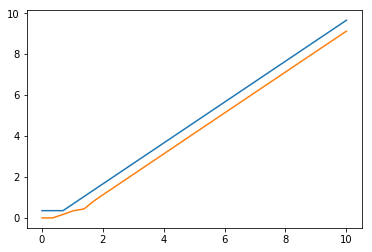

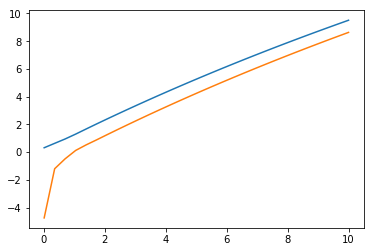

[6.49005875e+00 6.14557370e+00 5.80108826e+00 4.92649147e+00
 4.05100760e+00 3.70652147e+00 3.36203571e+00 3.01755108e+00
 2.67306588e+00 2.32858233e+00 1.98409818e+00 1.63961538e+00
 1.29513327e+00 9.50651289e-01 6.06169822e-01 3.54485380e-01
 3.54485964e-01 3.54485964e-01 3.54485964e-01 3.54485964e-01
 1.10464352e-05 3.54482847e-01 3.54485964e-01 1.10464387e-05
 3.54482847e-01 3.54485964e-01 3.54485964e-01 3.54485964e-01
 3.54485964e-01 3.54485964e-01 3.54485964e-01 3.54485964e-01
 3.54485964e-01 3.54485964e-01 3.54485964e-01 1.10464352e-05
 3.54482847e-01 3.54485964e-01 3.54485964e-01 3.54485964e-01
 3.54485964e-01 3.54485964e-01 1.10464352e-05 3.54482847e-01
 3.54485964e-01 3.54485964e-01 3.54485964e-01 3.54485964e-01
 3.54485964e-01 3.54485964e-01]
New value for Kstar 1.0913608457231219
Error term for Kstar:  29.145939097702147
R is 0.14342886526066173
Wage is 1.073969787810866


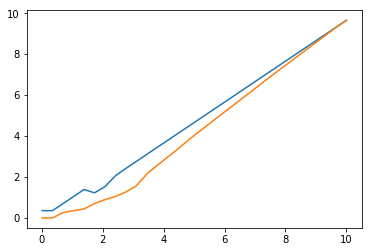

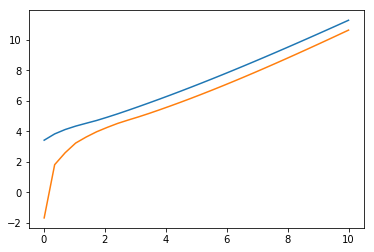

[3.79070980e+00 3.44622287e+00 3.10173899e+00 1.56689757e+00
 5.74544546e-01 5.74545333e-01 5.74546119e-01 5.74546906e-01
 5.74547692e-01 5.74548479e-01 5.74549265e-01 5.74550052e-01
 5.74550838e-01 5.74551625e-01 5.74552411e-01 5.74553198e-01
 5.74553984e-01 5.74554771e-01 5.74555557e-01 5.74556344e-01
 1.65813862e-01 3.54483040e-01 3.54485611e-01 1.01713907e-05
 3.54481027e-01 3.54485330e-01 3.54487901e-01 3.54490473e-01
 3.54493044e-01 3.54495615e-01 3.54498186e-01 3.54500758e-01
 3.54503329e-01 3.54505900e-01 3.54508471e-01 2.73943122e-05
 3.54481028e-01 3.54485330e-01 3.54487901e-01 3.54490473e-01
 3.54493044e-01 3.54495615e-01 1.77084436e-05 3.54481027e-01
 3.54485330e-01 3.54487901e-01 3.54490473e-01 3.54493044e-01
 3.54495615e-01 3.54498186e-01]
New value for Kstar 0.5447003945840347
Error term for Kstar:  10.536577057006374
R is 0.2051056290471281
Wage is 0.8782390469544358


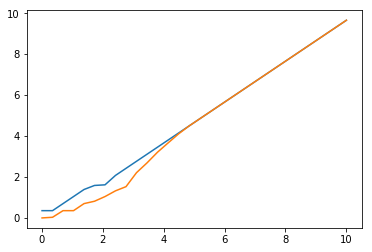

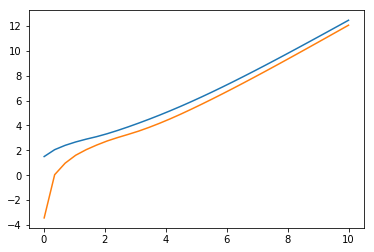

[2.1677051  1.73769599 1.58635317 0.76557162 0.35448224 0.3544877
 0.35449264 0.35449758 0.35450252 0.35450746 0.3545124  0.35451734
 0.35452228 0.35452723 0.35453217 0.35453711 0.35454205 0.35454699
 0.35455193 0.35455687 0.03147327 0.35448014 0.3544877  0.0314084
 0.35448014 0.3544877  0.35449264 0.35449758 0.35450252 0.35450746
 0.3545124  0.35451734 0.35452228 0.35452723 0.35453217 0.0314501
 0.35448014 0.3544877  0.35449264 0.35449758 0.35450252 0.35450746
 0.03142693 0.35448014 0.3544877  0.35449264 0.35449758 0.35450252
 0.35450746 0.3545124 ]
New value for Kstar 0.38989166932116204
Error term for Kstar:  3.1606205838402985
R is 0.2875175615842768
Wage is 0.7262755415161268


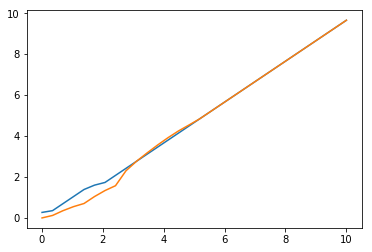

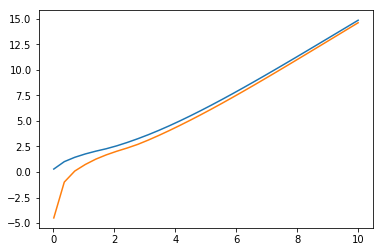

[1.27879838 1.27879858 1.27879878 0.65557964 0.32499378 0.34717148
 0.35267233 0.35403674 0.35437516 0.3544591  0.35447992 0.35448509
 0.35448812 0.35449115 0.35449418 0.35449721 0.35450024 0.35450327
 0.3545063  0.35450933 0.12036192 0.29641552 0.34008305 0.11531361
 0.29516336 0.33977247 0.35083712 0.35358154 0.35426226 0.3544311
 0.35447298 0.35448336 0.35448639 0.35448943 0.35449246 0.12035045
 0.29641267 0.34008235 0.35091398 0.35360061 0.35426698 0.35443227
 0.12032622 0.29640666 0.34008086 0.35091361 0.35360051 0.35426696
 0.35443226 0.35447327]
New value for Kstar 0.3721029921054115
Error term for Kstar:  0.8220965322129928
R is 0.38048310865885193
Wage is 0.6203852714680035


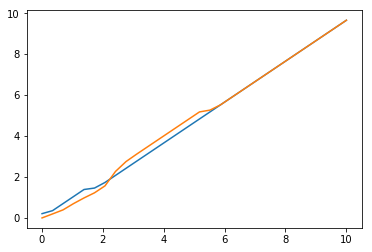

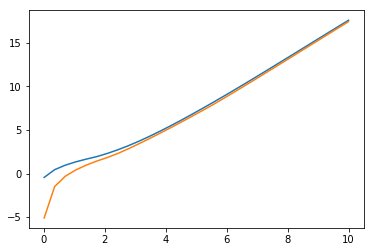

[0.82545069 0.8254504  0.82545011 0.50495318 0.28106535 0.32334192
 0.34127455 0.34888111 0.35210762 0.35347622 0.35405674 0.35430299
 0.35440744 0.35445174 0.35447054 0.35447851 0.35448189 0.35448332
 0.35448426 0.35448519 0.19473008 0.28672072 0.32574078 0.17848197
 0.27982869 0.32281736 0.34105205 0.34878673 0.35206758 0.35345924
 0.35404954 0.35429993 0.35440614 0.35445119 0.3544703  0.19472164
 0.28671714 0.32573926 0.34229144 0.34931245 0.35229058 0.35355383
 0.19420359 0.2864974  0.32564605 0.3422519  0.34929568 0.35228347
 0.35355081 0.35408838]
New value for Kstar 0.35138589864551784
Error term for Kstar:  0.22473742417141657
R is 0.4725182214612849
Wage is 0.549211585882181


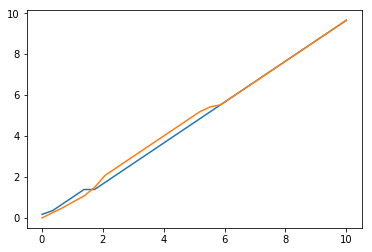

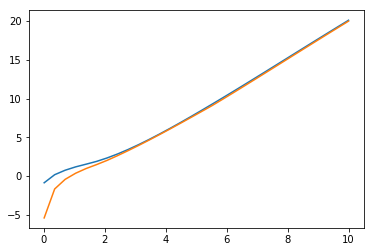

[0.58841829 0.58842232 0.58842635 0.42612117 0.30822058 0.3299929
 0.34152008 0.34762305 0.35085423 0.35256494 0.35347067 0.3539502
 0.35420408 0.3543385  0.35440966 0.35444734 0.35446729 0.35447785
 0.35448344 0.35448673 0.2561844  0.30244276 0.32693388 0.23569476
 0.29159468 0.32119045 0.33685969 0.34515565 0.34954788 0.35187331
 0.35310449 0.35375633 0.35410144 0.35428415 0.35438089 0.25610576
 0.30240112 0.32691183 0.33988883 0.3467594  0.35039697 0.35232285
 0.2545753  0.30159083 0.32648283 0.3396617  0.34663915 0.35033331
 0.35228915 0.35332465]
New value for Kstar 0.3461891800551132
Error term for Kstar:  0.05867494322902441
R is 0.5476135484684033
Wage is 0.5054851504444502


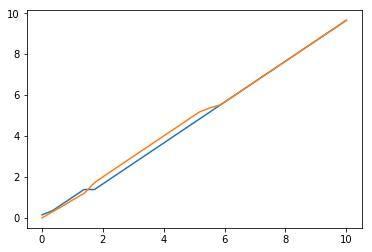

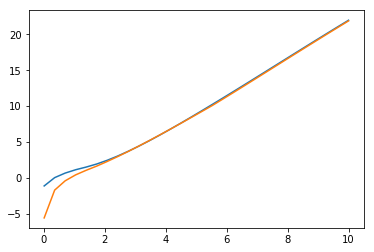

[0.46730374 0.46730465 0.46730555 0.39487763 0.33469986 0.34284737
 0.3476394  0.35045789 0.35211561 0.35309062 0.35366407 0.35400136
 0.35419974 0.35431642 0.35438504 0.3544254  0.35444914 0.35446311
 0.35447132 0.35447615 0.30113142 0.32310376 0.336027   0.28500388
 0.31361818 0.33044797 0.34034657 0.34616854 0.34959279 0.35160679
 0.35279135 0.35348806 0.35389783 0.35413885 0.3542806  0.30096048
 0.32300322 0.33596787 0.34359316 0.34807805 0.35071588 0.35226735
 0.29920058 0.32196811 0.33535906 0.34323508 0.34786744 0.35059201
 0.3521945  0.35313701]
New value for Kstar 0.34810150450793975
Error term for Kstar:  0.014209172135917884
R is 0.5975824918827713
Wage is 0.4812561934578045


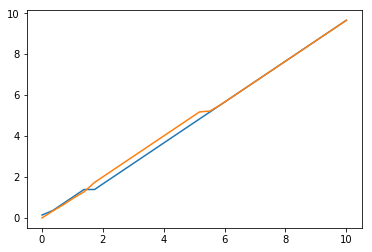

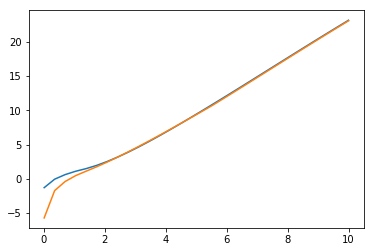

[0.40770262 0.40770526 0.4077079  0.37679593 0.34917861 0.35120473
 0.35245808 0.35323341 0.35371303 0.35400973 0.35419327 0.3543068
 0.35437703 0.35442048 0.35444736 0.35446398 0.35447427 0.35448063
 0.35448457 0.35448769 0.32924803 0.33887562 0.34483127 0.32001921
 0.33316665 0.34129969 0.3463308  0.34944306 0.35136831 0.35255928
 0.35329601 0.35375176 0.35403368 0.35420808 0.35431597 0.32908422
 0.33877429 0.34476858 0.34847667 0.3507705  0.35218947 0.35306725
 0.32789075 0.33803601 0.34431188 0.34819415 0.35059574 0.35208136
 0.35300037 0.35356887]
New value for Kstar 0.3512591899985725
Error term for Kstar:  0.003185860852906594
R is 0.6256567767066546
Wage is 0.4689872592928372


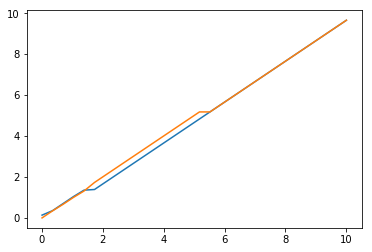

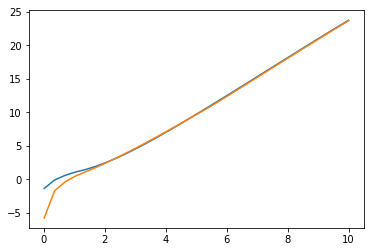

[0.37948091 0.37948403 0.37948714 0.36769363 0.35676547 0.35676881
 0.35677214 0.35677547 0.3567788  0.35678214 0.35678547 0.3567888
 0.35679213 0.35679546 0.3567988  0.35680213 0.35680546 0.35680879
 0.35681213 0.35681546 0.3466855  0.34954715 0.35135978 0.34140065
 0.34619959 0.34923936 0.35116482 0.35238445 0.353157   0.35364634
 0.35395631 0.35415265 0.35427701 0.35435579 0.35440569 0.34444688
 0.34812915 0.35046159 0.35193901 0.35287484 0.35346762 0.3538431
 0.34388424 0.34777276 0.35023584 0.35179602 0.35278427 0.35341025
 0.35380676 0.35405792]
New value for Kstar 0.35437050159486744
Error term for Kstar:  0.0006305323730529806
R is 0.6392749693745354
Wage is 0.46334107225000803


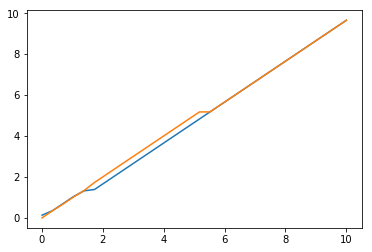

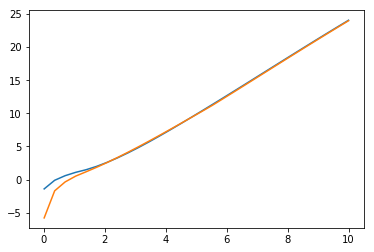

[0.3669257  0.36692868 0.36693166 0.36354675 0.36035716 0.36036014
 0.36036312 0.3603661  0.36036908 0.36037206 0.36037504 0.36037802
 0.360381   0.36038397 0.36038695 0.36038993 0.36039291 0.36039589
 0.36039887 0.36040185 0.35739374 0.35739672 0.35739969 0.35456482
 0.3545678  0.35457078 0.35457376 0.35457674 0.35457972 0.3545827
 0.35458568 0.35458866 0.35459164 0.35459462 0.3545976  0.35192441
 0.35284812 0.3534394  0.35381787 0.35406014 0.35421522 0.35431448
 0.35164435 0.35266885 0.35332464 0.35374442 0.35401312 0.35418512
 0.35429522 0.35436569]
New value for Kstar 0.3570103035665575
Error term for Kstar:  9.831515456435866e-05


In [3]:
Aiyagari(Kstar, Ustar, Π, Ε, Kgrid)

In [ ]:
print(Kstar)

In [ ]:
print(Ksimu)